# Ocean-Based Renewable Energy Generation

Visualizing electricity generation from marine and offshore wind by country over time

Note that this is a parameterized widget; the specification passed to the API will not be renderable without the geostore identifier being inserted. 

*Author: Rachel Thoms
<br>Created: 04 Aug 2021
<br>Environment: jupyterlab*

## Style

- Vega chart
- Vertical stacked bar chart
- Value is energy generation (GWh) for each subtechnology (marine and offshore wind)

## Data

- Data: [ow_widget_territory](https://resourcewatch.carto.com/u/wri-rw/dataset/ow_widget_territory) (full dataset - [ene.009_renewable_generation_annually](https://resourcewatch.carto.com/u/wri-rw/dataset/ene_009_renewable_generation_annually_edit))
- Resource Watch: [explore page](https://resourcewatch.org/data/explore/1ed420e2-9283-4ced-b7b6-d5268be7a324)
- Source: [IRENA](https://www.irena.org/Statistics/Download-Data)

## Preparation

### Aliasing and Inserting Data into the Widget Table

#### Queries

Individual Countries

``` SQL
INSERT INTO ow_widget_territory(section, widget, gid_0, name_0, variable, date, value, unit)
SELECT 'indicator' AS section, 'renewable energy generation' AS widget, alias.iso AS gid_0, alias.name_0 AS name_0, CONCAT(data.subtechnology, ' Energy') AS variable, data.year AS date, data.generation_gwh AS value, 'gWh' AS unit  
FROM (SELECT country_name, year, subtechnology, generation_gwh FROM "wri-rw".ene_009_renewable_generation_annually_edit WHERE (technology = 'Wind energy' AND subtechnology = 'Offshore Wind') OR technology = 'Marine energy') AS data
LEFT JOIN ow_aliasing_countries AS alias ON  data.country_name = alias.alias WHERE alias.iso IS NOT NULL
```

- countries with data: 28
- rows before: 152724
- rows inserted: 392
- rows after: 153116

World - Ocean

```sql
INSERT INTO ow_widget_territory(section, widget, gid_0, name_0, variable, date, value, unit)
SELECT 'indicator' AS section, 'renewable energy generation' AS widget, 'X01' AS gid_0, 'World' AS name_0, CONCAT(subtechnology, ' Energy') AS variable, year AS date, SUM(generation_gwh) AS value, 'gWh' AS unit FROM ene_009_renewable_generation_annually_edit WHERE (technology = 'Wind energy' AND subtechnology = 'Offshore Wind') OR technology = 'Marine energy' GROUP BY year, subtechnology
```

- rows before: 153116
- rows inserted: 38
- rows after: 153154

World - Total

Manually entered. Data from [Global Energy Statistical Yearbook](https://yearbook.enerdata.net/electricity/world-electricity-production-statistics.html)

- rows before: 153154
- rows inserted: 19
- rows after: 153173

### Vega

In [2]:
import json
from vega import Vega
from IPython.display import display

In [3]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [4]:
widget_width = 500
widget_height = 200

## Global Indicator Visualization

### Queries

#### Testing Version

```sql
SELECT date AS year, value, variable 
    FROM ow_widget_territory AS data  
LEFT OUTER JOIN  gadm36_0 gadm ON data.gid_0 = gadm.gid_0 
WHERE section = 'indicator' AND widget = 'renewable energy generation' 
AND  variable != 'Total Energy' 
AND gadm.geostore_prod ILIKE 'f4599aaeedacb9e6ddca177a93795e4c' 
ORDER BY year ASC
```

#### Parameterized Version

```sql
SELECT date AS year, value, variable 
    FROM ow_widget_territory AS data
LEFT OUTER JOIN  gadm36_0 gadm ON data.gid_0 = gadm.gid_0 
WHERE  section = 'indicator' AND widget = 'renewable energy generation' 
AND  variable != 'Total Energy' 
AND gadm.{{geostore_env}} ILIKE '{{geostore_id}}' 
ORDER BY year ASC
```

### Resource Watch Widget Config

In [5]:
spec=json.loads("""
{
  "autosize": {
    "type": "fit"
  },
  "padding": 5,
  "signals": [
    {
      "name": "hover",
      "value": null,
      "on": [
        {
          "events": "@cell:mouseover",
          "update": "datum"
        },
        {
          "events": "@cell:mouseout",
          "update": "null"
        }
      ]
    },
    {"name": "max", "update": "data('maximum')[0]['value']"}
  ],
  "data": [
    {
      "name": "data",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT date AS year, value, variable FROM ow_widget_territory AS data LEFT OUTER JOIN  gadm36_0 gadm ON data.gid_0 = gadm.gid_0 WHERE  section = 'indicator' AND widget = 'renewable energy generation' AND  variable != 'Total Energy' AND gadm.{{geostore_env}} ILIKE '{{geostore_id}}' ORDER BY year ASC",
      "format": {
        "type": "json",
        "property": "rows"
      }
    },
    {
      "name": "maximum",
      "source": "data",
      "transform": [{
          "type": "collect",
          "sort": {
            "field": ["value"],
            "order": ["descending"]
          }
        }
      ]
    },
    {"name": "table",
    "source":"data",
    "transform": [
      {
          "type": "collect",
          "sort": {
            "field": ["year"],
            "order": ["ascending"]
          }
        },
        {
          "type": "stack",
          "groupby": [
            "year"
          ],
          "sort": {
            "field": "variable",
            "order": "descending"
          },
          "field": "value"
        }
      ] }
  ],
  "scales": [
    {
      "name": "x",
      "type": "band",
      "range": "width",
      "domain": {
        "data": "table",
        "field": "year"
      }
    },
    {
      "name": "y",
      "type": "linear",
      "range": "height",
      "nice": true,
      "zero": true,
      "domain": {
        "data": "table",
        "field": "value"
      },
      "domainMax": {"signal": "max < 1 ? 10 : max"}
    },
    {
      "name": "legend",
      "type": "ordinal",
      "range": [
        "#84c0d0",
        "#005c7e"
      ],
      "domain": [
        "Marine Energy",
        "Offshore Wind Energy"
      ]
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "x",
      "zindex": 0,
      "labelBaseline": "middle",
      "ticks": true,
      "tickSize": 5,
      "labelFontSize": 10,
      "labelOverlap": true
    },
    {
      "orient": "left",
      "scale": "y",
      "zindex": 0,
      "title": "Energy Generation (GWh)",
      "titleFont": "Lato",
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 3,
      "grid": true,
      "gridOpacity": 0.2,
      "labelFontSize": 10,
      "encode": {
        "labels": {
          "update": {
            "text": {
              "signal": "format(datum.value, '.2s')"
            }
          }
        }
      }
    }
  ],
  "marks": [
    {
      "type": "rect",
      "from": {
        "data": "table"
      },
      "encode": {
        "enter": {
          "x": {
            "scale": "x",
            "field": "year"
          },
          "width": {
            "scale": "x",
            "band": 1,
            "offset": -1
          },
          "y": {
            "scale": "y",
            "field": "y0"
          },
          "y2": {
            "scale": "y",
            "field": "y1"
          },
          "fill": [
            {"test": "datum.variable === 'Offshore Wind Energy'",
            "value": "#005c7e"},
            {"value":"#84c0d0" }
          ]
        },
        "update": {
          "fillOpacity": {
            "value": 1
          }
        },
        "hover": {
          "fillOpacity": {
            "value": 0.5
          }
        }
      }
    }
  ],
  "legends": [
    {
      "title": [
        "Technology:"
      ],
      "titleFont": "Lato",
      "labelFont": "Lato",
      "fill": "legend",
      "orient": "right"
    }
  ],
  
    "interaction_config": [
    {
      "name": "tooltip",
      "config": {
        "fields": [
          {
            "column": "variable",
            "property": "Technology",
            "type": "text",
            "format": ""
          },
          {
            "column": "datum.date",
            "property": "Year",
            "type": "text",
            "format": ""
          },
          {
            "column": "value",
            "property": "Energy generation (Gwh)",
            "type": "number",
            "format": ",.0f"
          }

        ]
      }
    }
  ]
}
""")

Due to differences in default parameters in the Resource Watch Widget Editor, some minor changes need to be made to display the chart in the notebook

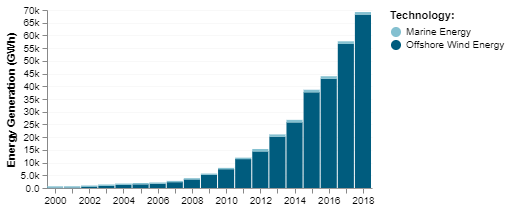

In [6]:
vega_view=dict(spec)
vega_view['height'] = widget_height
vega_view['width'] = widget_width
vega_view['axes'][0]['labelBaseline']= "top"
vega_view['legends'][0]['labelFont'] = 'Arial'
vega_view['legends'][0]['titleFont'] = 'Arial'
vega_view['axes'][1]['titleFont'] = 'Arial'
vega_view['data'][0]['url']= vega_view['data'][0]['url'].replace('{{geostore_env}}','geostore_prod')
vega_view['data'][0]['url'] = vega_view['data'][0]['url'].replace('{{geostore_id}}','fe855e0073d3a7c45ccd5f653841bb8d')
Vega(vega_view)

[Open the Chart in the Vega Editor](https://vega.github.io/editor/#/url/vega/N4IghgrgLg9gzgSwF4FMQC5RQJ4Ac3ogBmCUIAvgDQgDuCAJlABYYCsADO9UyggOZMy6AEydquMPXoIAdnzbVEfGWAA2cDAG1QKgLYEQTGADcUAJxDVjaiARkRVq6jBlbQKUzKgbCAAQDGKI7oujAQcCgm5pYgELj0YFAGCVAQuhSU7p7eGCABQaohYRFhZNRxKQb2jhQAuuS11ClgbiB6BlBgAEaqaOVmqrmCULhw6AD04zRmCAC0ZjQAdP5gZrDLMLrjYLgI48bC43AAjqoA-McAvADKAKIAMrcAwgAqAASVbwCC12-YKKtKG9rKpbEDrDNur03gAxABKAHkALJvGA0AD6dHofBQUHRSTMM1gZmw31+zTejxh7wRAFUXrc4W8AFIIgCSADk3m8+JJdABmABs6PYPL5bwRXOaiz4DBFb0uYvouhlctFAHUABKM27ciL+KAIFwKt4Aclk0hWxNN3w5ABE3licVATaazCgZCgaFCUG8PeY+KScZ6zIkjTIbV97dyIQgfW8AISK00vGCdVRvW4hwOR6O85Wq+jytn3NkAaV1poA4vcAEI2hFwu2Mt61gCafwBZjJTxiRBgZl0iQwWDwBgAVnAXDFcGYYPg1thcnOaBoqCAoKGZHB+4PWjh8Lk4J1-ABrGJ8OdxLpL9CaED-VYgRogKdrEfEBBBei5WM+mIDvQ0SEEBcCBDI0hyBkn7fr+NhoA0DSKCsvQ+NobRgPouQAB4xAeBhdGAEExFuOK5FizAxPQmxgLIH7NLknQ9H0MGqD+hCPhY5BUDomEGEu1D4bkqiyF2JFEWRhA8PwggxDICCBBgm5giAqBzkpZgqdRQ50ZgIAMYQTG9H2X5sXBoIITxGFYYQvTBj+gljrkgGyGo4lyAQ94AMQABwACz+Ow9DsDEXmcKw-gAOxoC+2m0a4d4gEiqyiZm2YCSACJEEQcBGO6bzqhaaUBku9QvmA2EoGhoADl+Xi5F0aawOkyFqAYuHUEgFooLh6BcCAqjdEEtZgBEImerkugMPQxmCQpp4+MpKBzWe1zIAQrDUINXRBDCLhQGtqAYAAjP1227ftuRfJCgxbUNqgIqYAw7BpthWbVHpCANKBEGUr4ofxMRdRBPUYP1hpQMZhBZiVbxVv6oaGsaAAUVbqkwACUMTnaoI1jaJk3TbNA33V8InKMuMl-TjAAKkiQfI6D8tQl4MK9y0gKz9AIhI-ikLe7CLMId07aoe1eIdBCnSLF31YQ11xrdIAev4MBAR+OM+KAFSJAQWA9UIoBKCogyELuQ5QMjKRpIsIJgmaQtwKaWPca7L5DmYC37k5hDugafZzukekGRu-7rirat68rXjAaAvVGwDOEmbBHFieuFEsHpYFtUn1CEcR6DHc42UREIszHeut4JznHHJ2ZHEhZXwgftnUMPnX7EPsd0EkDUd768euTWyqf7MQqlzJllOV5b6hUQcVZg5jEdsGGF7ARdFGSgCvuS+QFQWNy+sAwKohq4C3-Am7kwApig-hMDIJ8wDm6DD7bKU+pQpow4vQYI2GLhTToHNokZGV4IJW0SDbFeGMv5fwxm8AA1GaOG6NTTkAoOuHWSQPy9werzfmH4d6F24twKIFg9J4J5mAPmOAiHwTBosVgrskLfXstVDcpAob3heHfB+T9AyEBfHg4SKB7IARmJ9SmAgyCISAA)

# Indicator Value

## Country

```sql

SELECT CASE 
	WHEN ratio > 1 THEN CAST(ROUND(CAST(ratio AS numeric), 2) AS text) 
    WHEN ratio < 1 AND ratio > 0 THEN '<1'
    ELSE '0' 
    END AS value
    FROM 
        (SELECT 
            SUM (CASE 
                WHEN subtechnology IN ('Offshore Wind', 'Marine') 
                    THEN generation_gwh 
                ELSE 0 END)
            /SUM(generation_gwh)*100 AS ratio 
            FROM ene_009_renewable_generation_annually_edit 
INNER JOIN gadm36_0 gadm ON iso_a3 = gadm.gid_0 WHERE year=2018 
AND gadm.{{geostore_env}} ILIKE '{{geostore_id}}' 
GROUP BY iso_a3) data
```
raw: `https://wri-rw.carto.com/api/v2/sql?q=SELECT CASE WHEN ratio > 1 THEN CASTCAST(ROUND(CAST(ratio AS numeric), 2) AS text) WHEN ratio < 1 AND ratio > 0 THEN '<1' ELSE '0'  END AS value FROM (SELECT SUM(CASE WHEN subtechnology IN ('Offshore Wind', 'Marine') THEN generation_gwh ELSE 0 END)/SUM(generation_gwh)*100 AS ratio FROM ene_009_renewable_generation_annually_edit INNER JOIN gadm36_0 gadm ON iso_a3 = gadm.gid_0 WHERE year=2018 AND gadm.{{geostore_env}} ILIKE '{{geostore_id}}' GROUP BY iso_a3) data`



## World

```sql
SELECT  
    SUM(CASE 
        WHEN subtechnology IN ('Offshore Wind', 'Marine') THEN generation_gwh
        ELSE 0
        END)
        /SUM(generation_gwh)*100 proportion
FROM ene_009_renewable_generation_annually_edit 
INNER JOIN gadm36_0 gadm ON iso_a3 = gadm.gid_0 
WHERE year=2018 
```

```query```: [https://wri-rw.carto.com/api/v2/sql?q=SELECT SUM(CASE WHEN subtechnology IN ('Offshore Wind', 'Marine') THEN generation_gwh ELSE 0 END)/SUM(generation_gwh)*100 proportion FROM ene_009_renewable_generation_annually_edit INNER JOIN gadm36_0 gadm ON iso_a3 = gadm.gid_0 WHERE year=2018](https://wri-rw.carto.com/api/v2/sql?q=SELECT%20SUM(CASE%20WHEN%20subtechnology%20IN%20(%27Offshore%20Wind%27,%20%27Marine%27)%20THEN%20generation_gwh%20ELSE%200%20END)/SUM(generation_gwh)*100%20proportion%20FROM%20ene_009_renewable_generation_annually_edit%20INNER%20JOIN%20gadm36_0%20gadm%20ON%20iso_a3%20=%20gadm.gid_0%20WHERE%20year=2018)

## RW Backoffice

- [back office](https://resourcewatch.org/admin/data/widgets/3a6c3ff4-e1a5-4209-835d-40dabe37c1c5/edit?dataset=1ed420e2-9283-4ced-b7b6-d5268be7a324)
- parent dataset [ene_009](https://resourcewatch.org/data/explore/1ed420e2-9283-4ced-b7b6-d5268be7a324) 
- dataset id ```1ed420e2-9283-4ced-b7b6-d5268be7a324```
- widget id: ```3a6c3ff4-e1a5-4209-835d-40dabe37c1c5```